# Train a random-forest classifier

Let's see how a random forest can learn to distinguish misogynistic
speech from generic speech.

In [95]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [96]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, f1_score, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV

### Load the data

In [97]:
df = pd.read_csv("../data/processed/stanford.csv")

In [98]:
df.shape

(31014, 2)

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31014 entries, 0 to 31013
Data columns (total 2 columns):
text     31014 non-null object
label    31014 non-null int64
dtypes: int64(1), object(1)
memory usage: 484.7+ KB


### Balance classes

To avoid bias (i.e. when an algorithm prefers one class to the other) we need to have an equal number of elements for each class.

In [100]:
df.groupby('label').count()

,text
label,
0,11273
1,19741


One can see here that we have a different number of elements for the two
classes.
Let's change that.
First let's count the elements of the minority class.

In [101]:
n_elements = (df['label']==0).sum()
n_elements

11273

Then sample an equal number from the majority class.

In [102]:
df_positive = df[df['label']==1].sample(n_elements, random_state=42)
df_positive.head()

,text,label
10724,@DYKE_37 O que DST?,1
15443,A buzz cut does not a dyke make,1
7968,@my_suhr_guitar @KondratieffWave @NicolaSturge...,1
30805,@lovedayas THIS WASNT EVEN FUNNY BITCH OAK,1
30564,@DreadLegend_ Its gone be all worth it when im...,1


In [103]:
df_balanced = pd.concat((df[df['label']==0], df_positive)).reset_index(drop=True)
df_balanced

,text,label
0,The new Doras cute af,0
1,@minniemonikive well,0
2,@tangletorn We will be killed by a snake 3,0
3,@ATX_fight_club @AOC JFK was a clandestine aus...,0
4,@ocorreia_ @skank_ @duudamarquess_ eu tambm kk...,0
5,@AOC https//t.co/Ws2TTpXxAP,0
6,@AOC Zion,0
7,@DYKE_37 T pra frente hein,0
8,@AOC @RealGwenCarr Justice is a tricky concept...,0
9,@AOC Trumps a racist nut job and if anyone loo...,0


We store the balanced data in the original dataframe.

In [104]:
df = df_balanced

Now let's create the Spacy NLP documents from our text data.

First we need to load the language model.

In [105]:
nlp = spacy.load("en_core_web_md")

In [106]:
# The .pipe() method batch processes all the text
docs = list(nlp.pipe(df['text']))

### Vectors visualization

Here we take the document vectors from Spacy.

In [107]:
vector_matrix = np.array(list(map(lambda x: x.vector, docs)))

In [108]:
vector_matrix.shape

(22546, 300)

We use PCA to project the vectors to their principal components.

In [109]:
pca = PCA(2)

In [110]:
x_pca = pca.fit_transform(vector_matrix)

In [111]:
x_pca.shape

(22546, 2)

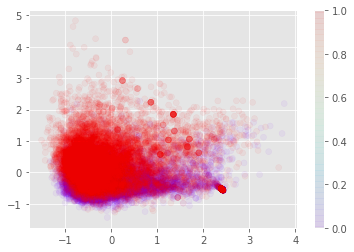

In [112]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=df['label'].tolist(), alpha=.05, cmap='rainbow');
plt.colorbar();

## Random forest classifier

The random forest algorithm is a pretty versatile one and generally
performs well.
Let's use the default parameters with just one change:
we'll use 100 trees.

In [113]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

### Train-test split

It's important to split the data consistently
so that we keep a 50/50 ratio both in training and test.

In [114]:
x_train, x_test, y_train, y_test = train_test_split(
    vector_matrix,
    df['label'].to_numpy(),
    train_size=.8,
    shuffle=True,
    stratify=df['label'],
    random_state=42,
)

In [115]:
x_train.shape

(18036, 300)

Let's check the class balance:

In [116]:
y_train.mean(), y_test.mean()

(0.5, 0.5)

And now we fit the model:

In [117]:
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Let's try the fitted model on the test set:

In [118]:
y_pred = rf.predict(x_test)

We can also extract probabilities.
The [1,0] prediction can always be recomputed
from the probabilities, knowing that the prediction is 1 when
the probability > 0.5 and 0 otherwise.

In [119]:
y_proba = rf.predict_proba(x_test)

There are several metrics to evaluate the performance of the model.
Common ones include the F1-score, the confusion matrix,
the ROC curve, and the area under the ROC curve (AUC).

In [120]:
f1_score(y_test, y_pred)

0.7707832772705431

Let's check what we get from the training data, just for fun:

In [121]:
f1_score(y_train, rf.predict(x_train))

0.9867564534231201

This is a very high value, which is expected since the training data has been used to train the model.

Let's look at what the prediction arrays look like.

In [122]:
y_pred

array([0, 0, 1, ..., 0, 0, 1])

In [123]:
y_proba

array([[0.53      , 0.47      ],
       [0.52666667, 0.47333333],
       [0.4575    , 0.5425    ],
       ...,
       [0.54      , 0.46      ],
       [0.66      , 0.34      ],
       [0.49      , 0.51      ]])

`y_proba` contains two columns, the first is the probability for class 0, the second is the probability
for class 1.

In [124]:
# This is a convenience function that takes care of boring stuff
def plot_roc_auc_f1(y_test, y_proba, title=None):
    f1 = f1_score(y_test, y_proba[:, 1]>.5)
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    auc_score = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(6,6))
    if title is not None:
        ax.set_title(title)
    ax.plot([0, 1], [0, 1], '--', label="Random")
    ax.plot(fpr, tpr, label="Your model")
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.annotate(f"AUC: {auc_score:.4}", (.8, 0.05))
    ax.annotate(f"F1: {f1:.4}", (.8, 0.0))
    ax.legend()
    return f1, auc_score

### ROC curve

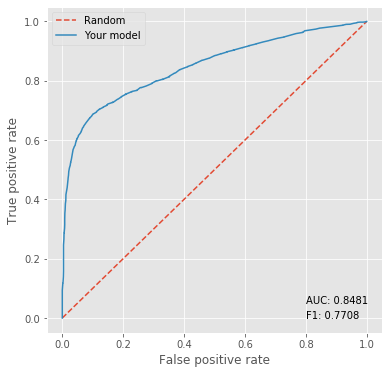

In [125]:
f1, auc_score = plot_roc_auc_f1(y_test, y_proba);

The straight line is equivalent to the performance of a random classifier.
The further away from it, the better.
The curve looks quite good and AUC=0.85 is a decent value.

### F1-score, AUC

In [126]:
f1, auc_score

(0.7707832772705431, 0.8481196257638852)

In [127]:
rf.n_features_

300

### A closer look at the predictions

In [128]:
df_train, df_test = train_test_split(
    df,
    train_size=.8,
    shuffle=True,
    stratify=df['label'],
    random_state=42,
)

In [129]:
df_train.shape

(18036, 2)

In [130]:
df_test.shape

(4510, 2)

In [131]:
df_test['prediction'] = y_proba[:, 1]

/home/tcake/coding_projects/python/opt_out/study-online-misogyny/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Let's take a look at what the model predicts.

In [132]:
df_test[df_test['prediction']>.5].sort_values('prediction', ascending=False)['text'].tolist()

['Convinced this bitch wanna fuck with me or some',
 'I hate this bitch https//t.co/NBn8NZKp86',
 '@cln_els23 YOU FUCKING BITCH',
 'bitch wttffffffff https//t.co/vIGC3z4BUz',
 '@woo_ahhh stupid bitch',
 'I hope the stupid fucking ass fuck in the black stupid bitch cunt ass truck chokes on a fucking lightbulb. Stupid fucking whore.',
 '@henderysjuul dyke',
 'This bitch https//t.co/nV3EbKWxWm',
 'this bitch bout Thtupid ath fuck she just REACHINNNGG for attention https//t.co/nqxUgmOwsr',
 'Nigga Cause Im about that yeah ya heard me. Other niggas Nigga Ill bat the fuck out you and your bitch and air this bitch out Nobody has thrown a punch yet',
 'WHORE https//t.co/QoqyRNar26',
 'I FUCKING HATE HYUN SUA SHES A FUCKING BITCH',
 '@foreveralex7 Fucking whore',
 'ill slap the fuck outta this nigga and this bitch on god',
 '@mimirosefanclub shut up whore',
 '@knukklehedd OH YOU FUCKING BITCH',
 '@shenanigone wow bitch can you calm down for once hoe ass',
 '@vorekhei dyke',
 '@QAdrama This bitc

In [133]:
df_test[df_test['prediction']<=.5].sort_values('prediction', ascending=False)['text'].tolist()

['@SluttierYote I think it fits you perfectly, really brings out your curves!',
 'I can tell you from personal experience, that one of the most racist person I ever met was Al Sharpton. Saw him @ 4 meetings in NYC.I was dressed professionally in a nice in a suit and high heels. I was Pres. of The NYC School Board. He looked me up and down w a dirty look! https//t.co/1nD7dZcgwN',
 '@AllisonMorris1 Remember Nuremberg',
 'Fedde le grandSKANK',
 '@mmpadellan @AOC Can you define Projection? If not refer back to your tweet',
 '@UnburntWitch Well today I learned and also explains why this one had me a lot more worried.',
 'Day 2 French lecturer says a dirty home is a home where the wife talks above the man. People really think this marriage of a thing a bondage between a master and a slave. The crime here is voicing your opinion as a woman.',
 '@porntagonist I have the cover saved to my phone for whenever I need to snap you out of a dirty pair trance',
 "A deal's a deal even with a dirty deal

### Visualization of probability distribution

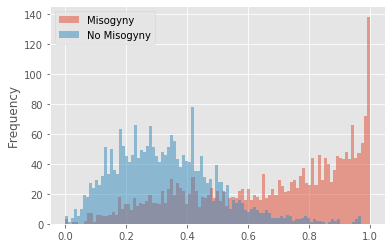

In [134]:
df_test['prediction'][df_test['label']==1].plot.hist(bins=99, alpha=.5, label="Misogyny")
df_test['prediction'][df_test['label']!=1].plot.hist(bins=99, alpha=.5, label="No Misogyny");
plt.legend();

## Parameter Optimization

One can fine-tune the model's hyperparameters in order to
find the best possible model.

In [135]:
estimator = RandomForestClassifier(n_jobs=-1, random_state=42)

In [136]:
# BEWARE: Searching for more than just a couple parameters will increase the calculation time exponentially!
param_grid = {
    "n_estimators": [50, 200],
#     "max_depth": [3, None],
#     "max_features": [1, 10, 100],
#     "min_samples_split": [10, 100, 1000],
#     "bootstrap": [True, False],
#     "criterion": ["gini", "entropy"],
}

In [137]:
grid_search = GridSearchCV(estimator, param_grid=param_grid, cv=5, iid=False, verbose=2, n_jobs=-1)

In [138]:
%%time
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.3min finished


CPU times: user 2min 18s, sys: 51.3 ms, total: 2min 18s
Wall time: 5min 48s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid=False, n_jobs=-1, param_grid={'n_estimators': [50

In [139]:
grid_search.cv_results_

{'mean_fit_time': array([ 35.10880055, 128.00320044]),
 'std_fit_time': array([ 0.51565492, 26.99964939]),
 'mean_score_time': array([0.23607812, 0.52265096]),
 'std_score_time': array([0.04018389, 0.09832141]),
 'param_n_estimators': masked_array(data=[50, 200],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 50}, {'n_estimators': 200}],
 'split0_test_score': array([0.76967849, 0.77466741]),
 'split1_test_score': array([0.78381375, 0.79268293]),
 'split2_test_score': array([0.77937916, 0.78575388]),
 'split3_test_score': array([0.77287854, 0.77981143]),
 'split4_test_score': array([0.78757626, 0.79062673]),
 'mean_test_score': array([0.77866524, 0.78470847]),
 'std_test_score': array([0.00664335, 0.00670097]),
 'rank_test_score': array([2, 1], dtype=int32)}

In [140]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [141]:
f1_score(y_test, grid_search.predict(x_test))

0.7688249400479616

In [142]:
y_proba = grid_search.predict_proba(x_test)

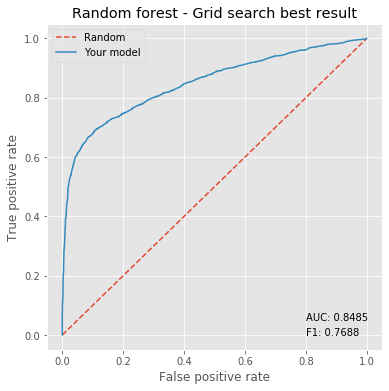

In [143]:
plot_roc_auc_f1(y_test, y_proba, title="Random forest - Grid search best result");

## Predict user input

Remember: 0 is not misogynistic, 1 is misogynistic.

In [144]:
best_rf = grid_search.best_estimator_

In [145]:
biatch = nlp("bitch").vector

In [146]:
best_rf.predict(biatch.reshape(1, -1))

array([1])

In [147]:
best_rf.predict(nlp("Have a nice day").vector.reshape(1, -1))

array([0])

Seems to be working!